# Clustering ETFs

This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [1]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cProfile

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

In [3]:
config_file = 'config/config_commodities_2010_2019.json'
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [4]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [5]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle')
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')
subsample = 2500
min_half_life = 78 #total de pontos num dia
file_extension = 'intraday'
# inter day
#df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_interpolated_screened')
#subsample=0
#min_half_life = 5
#file_extension = 'interday'

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2015',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)
train_val_split = '01-01-2016'

Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

78102

# 1. No Clustering

In [ ]:
no_cluster_series = pd.Series(0,index = df_prices_train.columns)
pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,#5,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample,
                                                            )
pairs_found_all_a_all = len(pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

In [455]:
print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))

Out of 4465.0 possible combinations


In [457]:
count = 0
pairs_aux = []
for pair in pairs_all_a_all:
    if pair[2]['hurst_exponent']<0.5:
        if pair[2]['p_value']<0.01:
            count += 1
            pairs_aux.append(pair)
print(count)

with open('data/etfs/pickle/2012-2016/pairs_no_clustering_'+file_extension+'.pickle', 'wb') as f:
    pickle.dump(pairs_aux, f)

101


# 2. Clustering by Category

In [281]:
segment_mapper = {
                'Commodities: Agriculture':'Agriculture',
                'Commodities: Agriculture Cocoa':'Agriculture',
                'Commodities: Agriculture Coffee':'Agriculture',
                'Commodities: Agriculture Corn':'Agriculture',
                'Commodities: Agriculture Cotton':'Agriculture',
                'Commodities: Agriculture Grains':'Agriculture',
                'Commodities: Agriculture Livestock':'Agriculture',
                'Commodities: Agriculture Softs':'Agriculture',
                'Commodities: Agriculture Soybeans':'Agriculture',
                'Commodities: Agriculture Sugar':'Agriculture',
                'Commodities: Agriculture Wheat':'Agriculture',
                'Equity: Global Water':'Agriculture',
                'Commodities: Broad Market':'Broad Market',
                'Commodities: Broad Market Metals':'Broad Market',
                'Commodities: Energy':'Energy',
                'Commodities: Energy Crude Oil':'Energy',
                'Commodities: Energy Gasoline':'Energy',
                'Commodities: Energy Natural Gas':'Energy',
                'Inverse Commodities: Energy Crude Oil':'Energy',
                'Inverse Commodities: Energy Natural Gas':'Energy',
                'Leveraged Commodities: Energy Crude Oil':'Energy',
                'Leveraged Commodities: Energy Natural Gas':'Energy',
                'Equity: U.S. MLPs':'Energy',
                'Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Energy':'Energy',
                'Equity: U.S. Oil & Gas Exploration & Production':'Energy',
                'Equity: U.S. Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas Exploration & Production':'Energy',
                'Equity: Global Energy':'Energy',
                'Equity: Global Nuclear Energy':'Energy',
                'Equity: Global Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Oil & Gas':'Energy',
                'Equity: U.S. Natural Gas':'Energy',
                'Equity: Global Coal':'Energy',
                'Leveraged Equity: U.S. Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Equity: China Energy':'Energy',
                'Leveraged Equity: U.S. Natural Gas':'Energy',
                'Commodities: Industrial Metals':'Industrial Metals',
                'Commodities: Industrial Metals Aluminum':'Industrial Metals',
                'Commodities: Industrial Metals Copper':'Industrial Metals',
                'Commodities: Industrial Metals Lead':'Industrial Metals',
                'Commodities: Industrial Metals Nickel':'Industrial Metals',
                'Commodities: Industrial Metals Tin':'Industrial Metals',
                'Equity: U.S. Metals & Mining':'Industrial Metals',
                'Equity: Global Metals & Mining':'Industrial Metals',
                'Commodities: Precious Metals':'Precious Metals',
                'Commodities: Precious Metals Gold':'Precious Metals',
                'Commodities: Precious Metals Palladium':'Precious Metals',
                'Commodities: Precious Metals Platinum':'Precious Metals',
                'Commodities: Precious Metals Silver':'Precious Metals',
                'Inverse Commodities: Precious Metals Gold':'Precious Metals',
                'Inverse Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Commodities: Precious Metals Gold': 'Precious Metals',
                'Leveraged Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Gold Miners':'Precious Metals',
                'Equity: Global Silver Miners':'Precious Metals',
                'Inverse Equity: Global Gold Miners':'Precious Metals'}

clustering_mapper = {'Agriculture':0,'Energy':1, 'Industrial Metals':2, 'Precious Metals':3, 'Broad Market': 4}

In [282]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

df_category = pd.DataFrame(data =df_prices_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
df_category['Category'] = df_category['Segment'].apply(lambda row: segment_mapper[row])
df_category['Category_cluster'] = df_category['Category'].apply(lambda row: clustering_mapper[row])
df_category = df_category.set_index('Ticker')

ticker_category_dict = pd.Series(df_category.Category.values,index=df_category.index).to_dict()
with open('data/etfs/pickle/ticker_category_dict.pickle', 'wb') as handle:
    pickle.dump(ticker_category_dict, handle)

In [284]:
print('Trading days: ', len(np.unique(df_prices_train.index.date))+len(np.unique(df_prices_test.index.date)))
print('Begin: ', df_prices_train.index.date[0])
print('End: ', df_prices_test.index.date[-1])
print('Samples: {}: {}-{}-{} '.format(len(df_prices_train+df_prices_test), len(df_prices_train[:train_val_split]),
                                      len(df_prices_train[train_val_split:]), len(df_prices_test)))
print(df_category['Category'].value_counts())
combinations = 0
for i,count in enumerate(df_category['Category'].value_counts().values):
    combinations += count*(count-1)
print('Possible number of pairs: ', combinations)

Trading days:  2515
Begin:  2009-01-02
End:  2018-12-28
Samples: 195414: 156516-19506-19392 
Energy               29
Precious Metals      13
Agriculture           7
Broad Market          7
Industrial Metals     2
Name: Category, dtype: int64
Possible number of pairs:  1054


In [394]:
pairs_category, unique_tickers = series_analyser.get_candidate_pairs(
                                                            clustered_series=df_category['Category_cluster'],
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample,
                                                            )

pairs_found_category = len(pairs_category)

Cluster 5/5Found 139 pairs
The pairs contain 62 unique tickers


In [398]:
count = 0
pairs_aux = []
for pair in pairs_category:
    if pair[2]['hurst_exponent']<0.5:
        if pair[2]['p_value']<0.01:
            count += 1
            pairs_aux.append(pair)
print(count)

#with open('data/etfs/pickle/2012-2016/pairs_category_'+file_extension+'.pickle', 'wb') as f:
#    pickle.dump(pairs_aux, f)

59


In [270]:
categories_found = pd.Series([ticker_category_dict[pair[0]] for pair in pairs_aux])
categories_found.value_counts()

Energy             40
Precious Metals    11
dtype: int64

In [ ]:
# examples
for i in range(6):
    plt.figure(figsize=(10,5))
    pairs_category[i][2]['X_train'].plot()
    pairs_category[i][2]['Y_train'].plot()

# 3. Clustering using Usupervised Learning

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [10]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DGL,...,SOYB,UCI,UGAZ,UNL,URA,USCI,WEAT,YMLI,YMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 14:40:00,0.001329,0.000000,-0.001186,0.000000,0.000555,0.002335,0.003237,0.000756,-0.004782,0.000000,...,0.000000,-0.003667,0.018850,0.006475,0.002385,-0.000791,0.000000,0.000000,-0.008628,-0.000994
2015-01-02 14:45:00,0.002044,0.000000,0.000409,-0.001208,-0.000554,-0.000597,-0.001251,0.000000,-0.000404,0.000000,...,0.000000,0.000000,0.007026,0.002144,0.000149,0.000000,-0.007855,0.005205,-0.004727,0.002653
2015-01-02 14:50:00,-0.003364,0.000000,-0.000409,-0.000637,-0.000499,-0.000538,-0.001319,0.000000,0.000000,0.000000,...,-0.004961,0.000000,0.000000,0.000000,-0.004658,0.000083,0.000000,0.000000,0.007941,-0.000248
2015-01-02 14:55:00,-0.003189,0.000000,0.001596,-0.000319,0.000777,0.000000,0.000990,0.000000,0.000000,0.000079,...,0.000000,0.000000,0.002326,0.000000,0.000000,0.000958,-0.001584,0.000000,-0.005510,0.001241
2015-01-02 15:00:00,-0.000267,-0.004225,-0.000777,0.000000,-0.000776,-0.000598,-0.002968,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016241,0.000000,0.000000,0.000000,-0.000793,0.000000,0.000000,0.000496


In [11]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  6670.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [296]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[4.21020937e-04 2.53918900e-04 1.18959373e-04 4.23544781e-05
 3.58596543e-05 2.39509310e-05 1.90537433e-05 1.85308477e-05
 1.58314932e-05 1.45527324e-05 1.32245537e-05 1.28298034e-05
 1.11642367e-05 1.07961808e-05 1.04234016e-05 9.86016719e-06
 9.12791436e-06 8.98780978e-06 8.45723400e-06 7.84607699e-06]


In [12]:
N_PRIN_COMPONENTS = 5#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns, 
                                                  random_state=12)
print(explained_variance)

[3.65048377e-04 2.39087571e-04 1.13016946e-04 3.75321036e-05
 3.26022316e-05]


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [13]:
#clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(0.8,#config['clustering']['epsilon'],
#                                                                                   2,#config['clustering']['min_samples'],
#                                                                                   X,
#                                                                                   df_returns)

In [14]:
# optics
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_OPTICS(X, df_returns, min_samples=3,
                                                                                   #max_eps=5, 
                                                                                   cluster_method='xi')

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30, max_eps=2,
       metric='euclidean', metric_params=None, min_cluster_size=None,
       min_samples=3, n_jobs=None, p=2, predecessor_correction=True, xi=0.05)
Clusters discovered: 17
Pairs to evaluate: 117


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [15]:
print(counts)
print('Average cluster size: ', np.mean(counts))

4     9
3     5
15    5
7     5
6     4
1     4
2     4
10    4
16    3
5     3
8     3
9     3
11    3
12    3
13    3
14    3
0     3
dtype: int64
Average cluster size:  3.9411764705882355


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [226]:
#config['clustering']={"algo": "DBSCAN",
#                      "epsilon": 0.4,
#                      "min_samples": 2}
#X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(1,
#                                                                                  20,
#                                                                                  df_returns,
#                                                                                  config['clustering'])

**Fundamental analysis for clusters**

In [227]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [202]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
   Ticker                                      Segment
96    DBS          Commodities: Precious Metals Silver
62    DGP  Leveraged Commodities: Precious Metals Gold
40   SIVR          Commodities: Precious Metals Silver
24    SLV          Commodities: Precious Metals Silver
64    UGL  Leveraged Commodities: Precious Metals Gold

Cluster 1:
   Ticker                                 Segment
55    DBP            Commodities: Precious Metals
59    DGL       Commodities: Precious Metals Gold
22    GLD       Commodities: Precious Metals Gold
39   GLTR            Commodities: Precious Metals
23    IAU       Commodities: Precious Metals Gold
44   PALL  Commodities: Precious Metals Palladium
32   PPLT   Commodities: Precious Metals Platinum
29   SGOL       Commodities: Precious Metals Gold

Cluster 2:
   Ticker                            Segment
2    CORN      Commodities: Agriculture Corn
0     DBA           Commodities: Agriculture
18    RJA           Commodities: Agriculture
5   

**Visualizing with t-sne**

In [203]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,10))
    plt.clf()
    plt.axis('off')

    # etfs in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]+20, y[i]+20))

    # remaining etfs, not clustered
    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)
    plt.scatter(
        x,
        y,
        s=100,
        alpha=0.10
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})
        
    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');
    
    # include connections - see quontopian

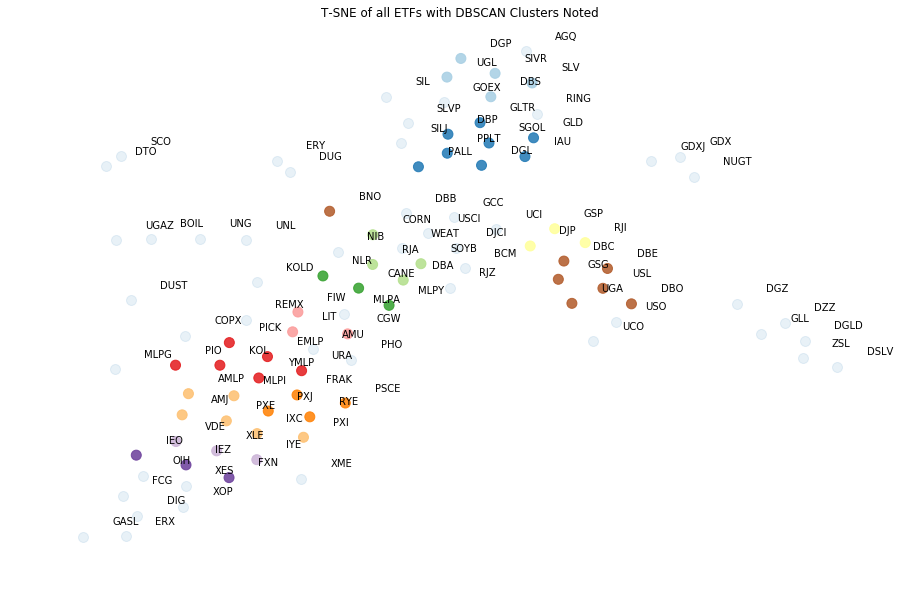

In [204]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

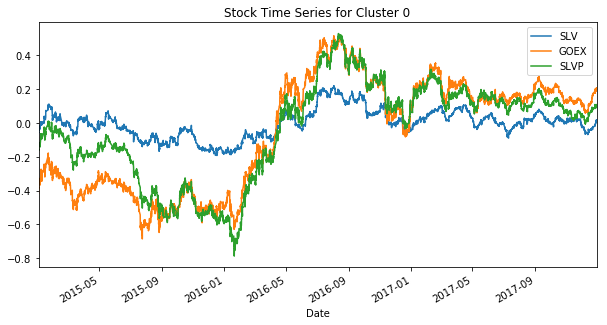

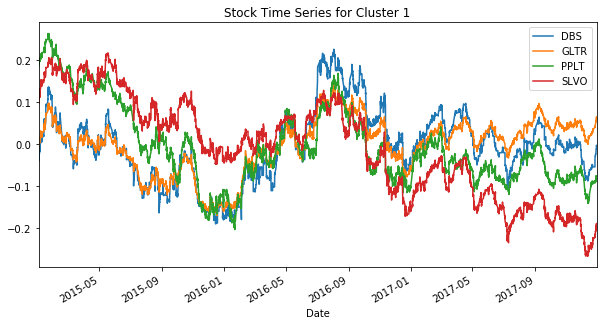

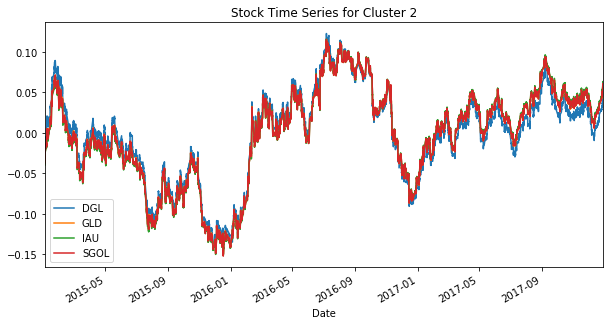

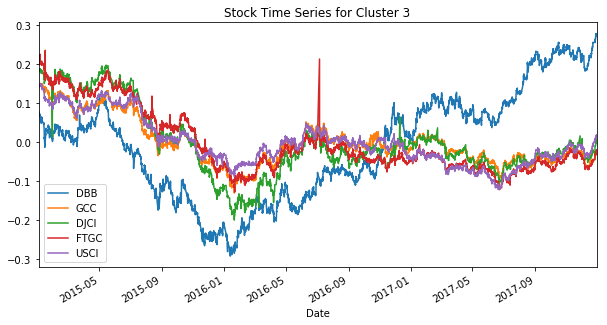

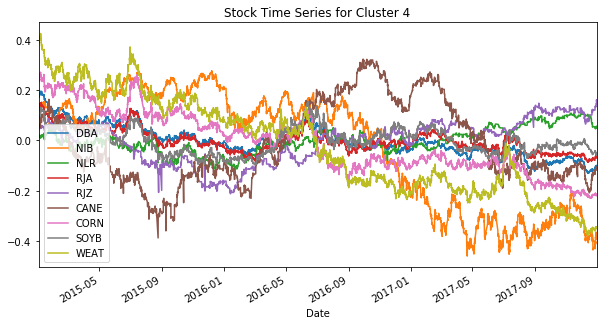

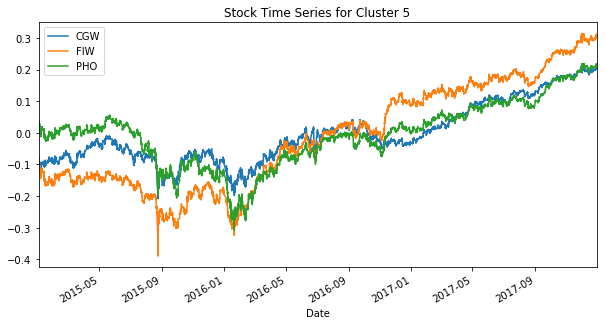

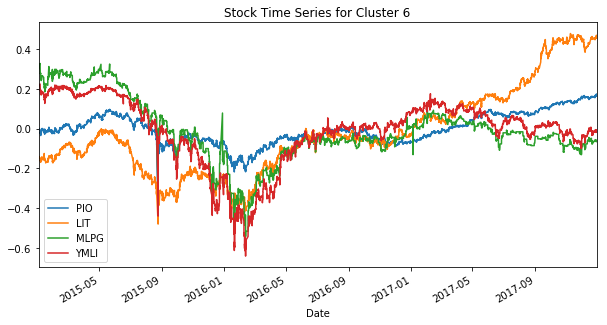

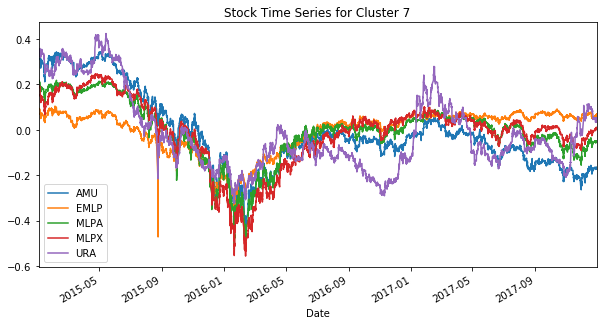

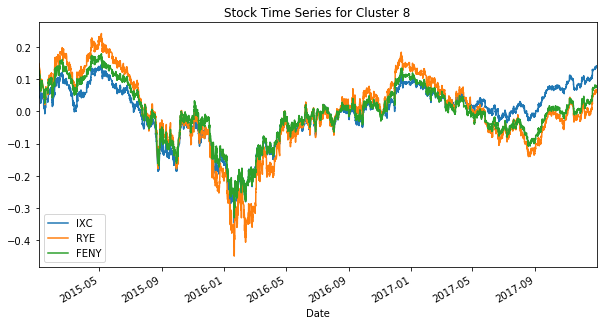

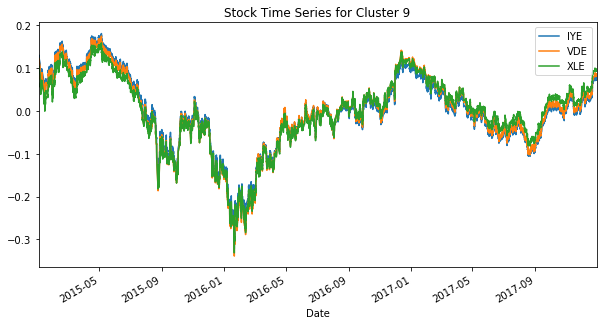

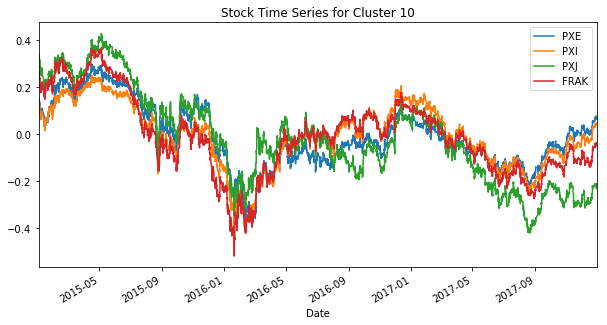

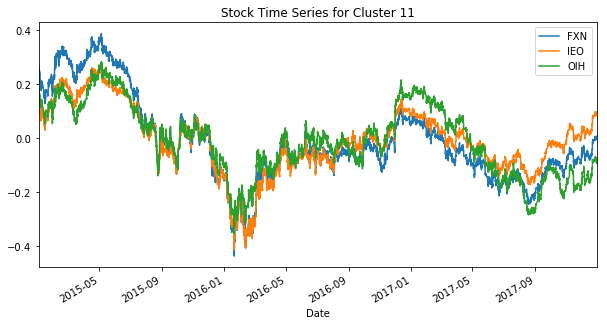

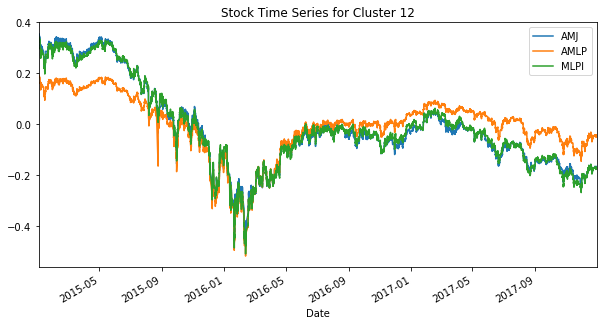

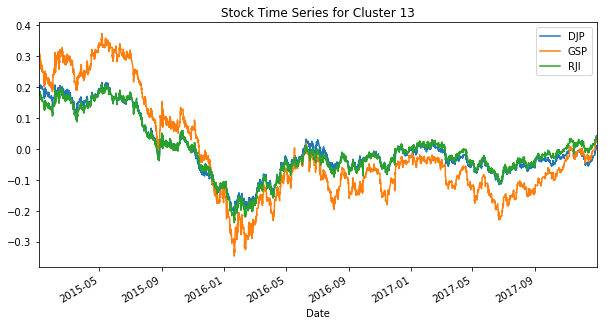

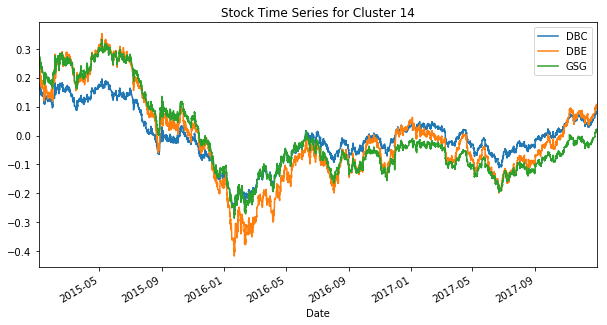

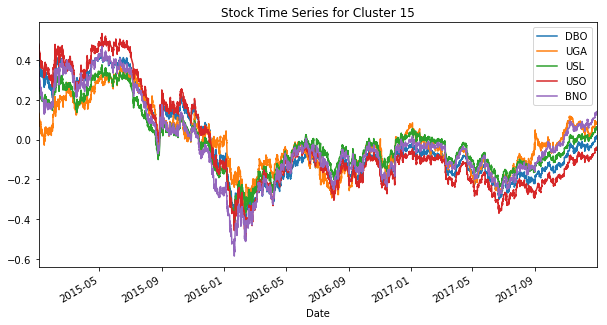

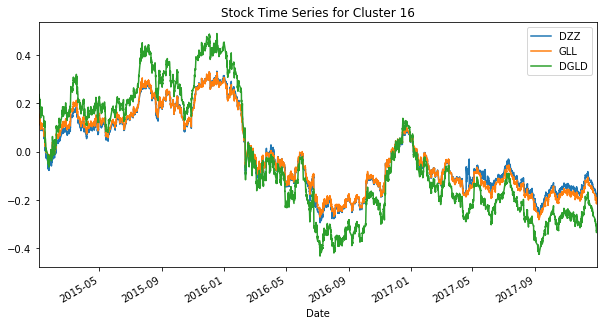

In [16]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [17]:
pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=min_half_life,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.10,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )

Cluster 17/17Found 23 pairs
The pairs contain 33 unique tickers


In [18]:
pairs_aux = []
for pair in pairs_unsupervised:
    if pair[2]['hurst_exponent']<0.5:
        if pair[2]['p_value']<0.05:
            # filter by volatility
            spread = pair[2]['spread']
            spread_pct_change = (((spread - spread.shift(1)) / abs(spread.shift(1))) * 100).fillna(0)
            spread_actual_changes = spread_pct_change[spread_pct_change != 0].abs()
            threshold = spread_actual_changes.quantile(q=0.95, interpolation='linear')
            #if threshold > 5: 
            pairs_aux.append(pair)
print(len(pairs_aux))

with open('data/etfs/pickle/2015-2019/pairs_unsupervised_learning_optical_'+file_extension+'.pickle', 'wb') as f:
    pickle.dump(pairs_aux, f)

14


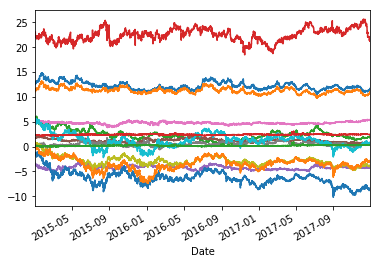

In [19]:
for i in range(len(pairs_aux)):
    pairs_aux[i][2]['spread'].plot()

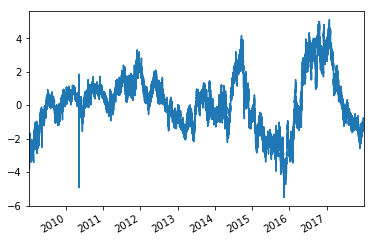

In [195]:
#pairs_aux[0][2]['X_train']['2010-05-06 18:00:00':'2010-05-07']
#pairs_aux[0][2]['Y_train']['2010-05-06 19:05:00']=24.758
(pairs_aux[0][2]['Y_train'] - pairs_aux[0][2]['coint_coef']*pairs_aux[0][2]['X_train']).plot()

In [21]:
for i in range(len(pairs_aux)):
    print('{}-{}'.format(pairs_aux[i][0], pairs_aux[i][1]))

DBA-RJZ
DBE-GSP
GCC-RJA
PXE-PXI
RJA-RJZ
DGP-UGL


In [34]:
count_different_category = 0
for pair in pairs_aux:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], df_category.loc[pair[0]]['Segment'] ,
                                                        df_category.loc[pair[0]]['Category']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], df_category.loc[pair[1]]['Segment'],
                                                        df_category.loc[pair[1]]['Category']))
    if df_category.loc[pair[0]]['Category'] != df_category.loc[pair[1]]['Category']:
        count_different_category += 1
print('There are {} pairs from different categories'.format(count_different_category))

------------------------------------------------
Leg 1: DGP. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
Leg 2: SLV. Segment: Commodities: Precious Metals Silver. Category: Precious Metals
------------------------------------------------
Leg 1: DGP. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
Leg 2: SIVR. Segment: Commodities: Precious Metals Silver. Category: Precious Metals
------------------------------------------------
Leg 1: SLV. Segment: Commodities: Precious Metals Silver. Category: Precious Metals
Leg 2: UGL. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
------------------------------------------------
Leg 1: UGL. Segment: Leveraged Commodities: Precious Metals Gold. Category: Precious Metals
Leg 2: SIVR. Segment: Commodities: Precious Metals Silver. Category: Precious Metals
------------------------------------------------
Leg 1: DBA. Segment: Commodities: Agriculture. Ca

In [197]:
for pair in pairs_aux:
    print('\nNew pair:')
    spread = pair[2]['spread']
    spread_pct_change = (((spread - spread.shift(1)) / abs(spread.shift(1))) * 100).fillna(0)
    spread_actual_changes = spread_pct_change[spread_pct_change != 0].abs()
    #negative_changes = spread_pct_change[spread_pct_change < 0]
    threshold = spread_actual_changes.quantile(q=0.95, interpolation='linear')
    print('threshold: {:.2f}'.format(threshold))


New pair:
threshold: 56.14

New pair:
threshold: 1.59

New pair:
threshold: 8.54

New pair:
threshold: 1.48

New pair:
threshold: 96.43


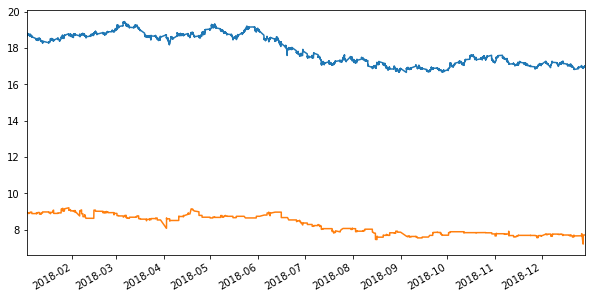

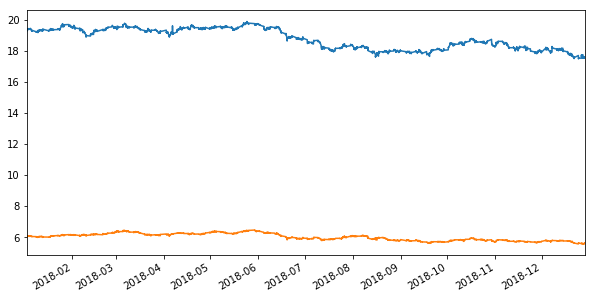

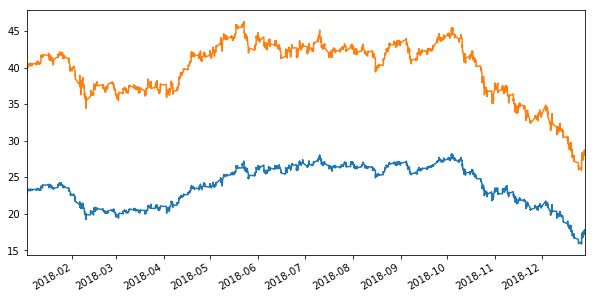

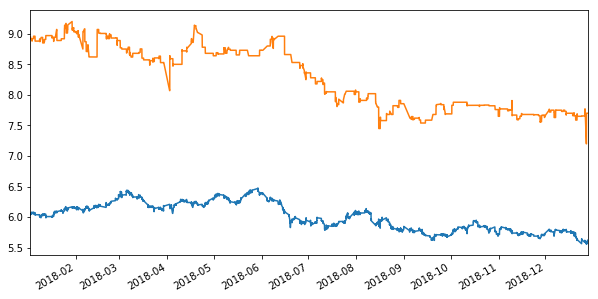

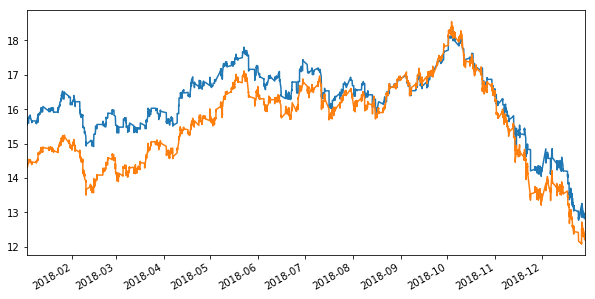

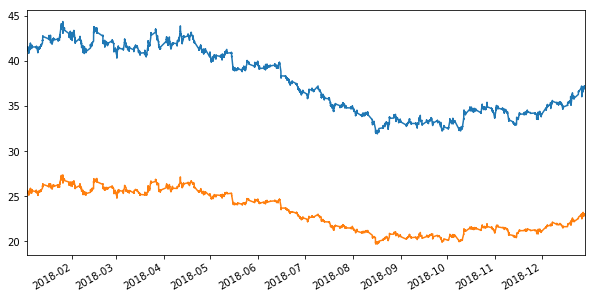

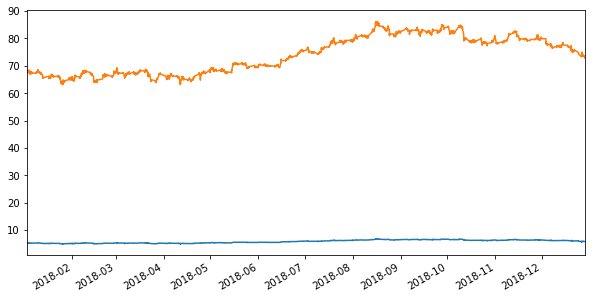

In [134]:
# examples
for i in range(len(pairs_aux)):
    plt.figure(figsize=(10,5))
    pairs_aux[i][2]['X_test'].plot()
    pairs_aux[i][2]['Y_test'].plot()

In [147]:
#Understanding return sequences

In [136]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
import keras
k_init = keras.initializers.Constant(value=0.1)
b_init = keras.initializers.Constant(value=0)
r_init = keras.initializers.Constant(value=0.1)
# LSTM units
units = 1

# define model
inputs1 = Input(shape=(6, 1))
lstm1 = LSTM(units, return_sequences=True, kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init)(inputs1)
model = Model(inputs=inputs1, outputs=lstm1)
# define input data
data = array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3]).reshape((1,6,1))
# make and show prediction
output = model.predict(data)
print(output, output.shape)

[[[0.00251993]
  [0.00692564]
  [0.01276855]
  [0.01174232]
  [0.0136829 ]
  [0.01773554]]] (1, 6, 1)


In [143]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
import keras
k_init = keras.initializers.Constant(value=0.1)
b_init = keras.initializers.Constant(value=0)
r_init = keras.initializers.Constant(value=0.1)
# LSTM units
units = 1

# define model
inputs1 = Input(shape=(6, 1))
lstm1 = LSTM(units, return_sequences=True, kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init)(inputs1)
model = Model(inputs=inputs1, outputs=lstm1)
# define input data
data = array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3]).reshape((1,6,1))
# make and show prediction
output = model.predict(data)
print(output, output.shape)

[[[0.00251993]
  [0.00692564]
  [0.01276855]
  [0.01174232]
  [0.0136829 ]
  [0.01773554]]] (1, 6, 1)


In [150]:
# LSTM units
units = 1

# define model
inputs1 = Input(shape=(6, 1))
lstm1 = LSTM(units, return_sequences=True, kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init)(inputs1)
model = Model(inputs=inputs1, outputs=lstm1)
# define input data
data = array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3]).reshape((1,6,1))
print(data)
# make and show prediction
output = model.predict(data)
print(output, output.shape)

[[[0.1]
  [0.2]
  [0.3]
  [0.1]
  [0.2]
  [0.3]]]
[[[0.00251993]
  [0.00692564]
  [0.01276855]
  [0.01174232]
  [0.0136829 ]
  [0.01773554]]] (1, 6, 1)


- O estado propaga-se apenas entre o memso batch. Para também se propagar entre diversos batches é necessário usar o stateful=True

In [211]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([40, 50, 60, 70])
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[84.48123]]


In [213]:
# Recurrent Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM
input_layer = Input(shape=(3,1))
hidden1 = LSTM(50,activation='relu', return_sequences=False)(input_layer)
output = Dense(1)(hidden1)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')

X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([40, 50, 60, 70])
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[84.243576]]


In [207]:
# Recurrent Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM
input_layer = Input(shape=(3,1))
hidden1 = LSTM(50,activation='relu', return_sequences=True)(input_layer)
output = TimeDistributed(Dense(1))(hidden1)
#output = Dense(1)(hidden1)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
#plot_model(model)

X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[20, 30, 40], [30, 40, 50], [40, 50, 60], [50, 60, 70]])
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((X.shape[0], X.shape[1], 1))
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[61.587315]
  [70.79778 ]
  [81.839775]]]
